# Training a Graphormer

In this notebook, we'll train a graphormer (graph transformer) to perform a graph-level task on a molecule dataset. Specifically, we will be able to predict various attributes of molecules, including the toxicity of each molecule on 12 different targets, as well as the water solubility of each molecule.

We will be using the OGB Molecule dataset for training and evaluation.



# Package installation

We first install the required packages. Note that installation might take some time.

In [3]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ogb  # for datasets

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 67.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.3 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-cg9ijll9
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-cg9ijll9
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit f506499f3bc0c227c882704e0a164b07213cd6a3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 4.7 MB/s eta 0:00:00
  Created wh

In [4]:
pip install cython

In [5]:
%load_ext cython

# Data Pipeline

Below, we implement a few useful functions using cython to accelerate our pipeline. It is not required for you to read or understand the code below.


In [6]:
%%cython

import cython
from cython.parallel cimport prange, parallel
cimport numpy
import numpy

## Floyd Warshall computes the shortest path in a weighted graph
def floyd_warshall(adjacency_matrix):

    (nrows, ncols) = adjacency_matrix.shape
    assert nrows == ncols
    cdef unsigned int n = nrows

    adj_mat_copy = adjacency_matrix.astype(long, order='C', casting='safe', copy=True)
    assert adj_mat_copy.flags['C_CONTIGUOUS']
    cdef numpy.ndarray[long, ndim=2, mode='c'] M = adj_mat_copy
    cdef numpy.ndarray[long, ndim=2, mode='c'] path = numpy.zeros([n, n], dtype=numpy.int64)

    cdef unsigned int i, j, k
    cdef long M_ij, M_ik, cost_ikkj
    cdef long* M_ptr = &M[0,0]
    cdef long* M_i_ptr
    cdef long* M_k_ptr

    # set unreachable nodes distance to 510
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i][j] = 0
            elif M[i][j] == 0:
                M[i][j] = 510

    # floyed algo
    for k in range(n):
        M_k_ptr = M_ptr + n*k
        for i in range(n):
            M_i_ptr = M_ptr + n*i
            M_ik = M_i_ptr[k]
            for j in range(n):
                cost_ikkj = M_ik + M_k_ptr[j]
                M_ij = M_i_ptr[j]
                if M_ij > cost_ikkj:
                    M_i_ptr[j] = cost_ikkj
                    path[i][j] = k

    # set unreachable path to 510
    for i in range(n):
        for j in range(n):
            if M[i][j] >= 510:
                path[i][j] = 510
                M[i][j] = 510

    return M, path


def get_all_edges(path, i, j):
    cdef unsigned int k = path[i][j]
    if k == 0:
        return []
    else:
        return get_all_edges(path, i, k) + [k] + get_all_edges(path, k, j)


## Generates a 4D tensor of shape (num_nodes, num_nodes, max_path_length, edge_feature_size)
## [i,j,k,:] stores the node features of the edge from path[k] and path[k+1] where path is the shortest path between i and j.
def gen_edge_input(max_dist, path, edge_feat):

    (nrows, ncols) = path.shape
    assert nrows == ncols
    cdef unsigned int n = nrows
    cdef unsigned int max_dist_copy = max_dist

    path_copy = path.astype(long, order='C', casting='safe', copy=True)
    edge_feat_copy = edge_feat.astype(long, order='C', casting='safe', copy=True)
    assert path_copy.flags['C_CONTIGUOUS']
    assert edge_feat_copy.flags['C_CONTIGUOUS']

    cdef numpy.ndarray[long, ndim=4, mode='c'] edge_fea_all = -1 * numpy.ones([n, n, max_dist_copy, edge_feat.shape[-1]], dtype=numpy.int64)
    cdef unsigned int i, j, k, num_path, cur

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if path_copy[i][j] == 510:
                continue
            path = [i] + get_all_edges(path_copy, i, j) + [j]
            num_path = len(path) - 1
            for k in range(num_path):
                edge_fea_all[i, j, k, :] = edge_feat_copy[path[k], path[k+1], :]

    return edge_fea_all

Content of stderr:
In file included from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_21c102fac3eb95e5053ceda14e0096f57188c0bc.c:1250:
/usr/local/lib/python3.11/dist-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

## Question 1 (10 points)

The code below defines some functions to preprocess the graphs in our dataset for use in the graphormer.

In the relevant section of the code below, construct a Boolean adjacency matrix `adj` using the `edge_index` attribute of the input graph.

In [7]:
import torch
import numpy as np

## This function is used to ensure that each feature is non-overlapping.
def convert_to_single_emb(x, offset=512):
    feature_num = x.size(1) if len(x.size()) > 1 else 1
    feature_offset = 1 + torch.arange(0, feature_num * offset, offset, dtype=torch.long)
    x = x + feature_offset
    return x

## Preprocesses each graph for use in model
def preprocess_item(item):
    ## item is a graph in our dataset.
    edge_attr, edge_index, x = item.edge_attr, item.edge_index, item.x

    N = x.size(0)
    x = convert_to_single_emb(x)

    ## Question 1: Construct an adjacency matrix of size (N, N) named 'adj' and dtype=torch.bool using edge_index
    ############# Your code here ############
    ## (~2 lines of code)

    adj = torch.zeros((N, N), dtype=torch.bool)
    adj[edge_index[0], edge_index[1]] = True

    #########################################


    ## edge_attr is of shape (num_edges, edge_feature_dim)
    ## attn_edge_type is of shape (N, N, edge_feature_dim)
    if len(edge_attr.size()) == 1:
        edge_attr = edge_attr[:, None]
    attn_edge_type = torch.zeros([N, N, edge_attr.size(-1)], dtype=torch.long)
    attn_edge_type[edge_index[0, :], edge_index[1, :]] = convert_to_single_emb(edge_attr) + 1

    shortest_path_result, path = floyd_warshall(adj.numpy())
    max_dist = np.amax(shortest_path_result)
    edge_input = gen_edge_input(max_dist, path, attn_edge_type.numpy())
    rel_pos = torch.from_numpy((shortest_path_result)).long()
    attn_bias = torch.zeros(
        [N + 1, N + 1], dtype=torch.float)  # + 1 to account for graph-level token

    # Add the relevant tensors as attributes of the graph
    item.x = x
    item.adj = adj
    item.attn_bias = attn_bias
    item.attn_edge_type = attn_edge_type
    item.rel_pos = rel_pos
    item.in_degree = adj.long().sum(dim=1).view(-1)
    item.out_degree = adj.long().sum(dim=0).view(-1)
    item.edge_input = torch.from_numpy(edge_input).long()

    return item

You can test the function `preprocess_item` using the code below.

In [8]:
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                       [1, 0, 2, 1]], dtype=torch.long)
edge_attr = torch.rand(4, 3).long()
x = torch.tensor([[-1], [0], [1]], dtype=torch.long)

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
data = preprocess_item(data)
print(data)

Data(x=[3, 1], edge_index=[2, 4], edge_attr=[4, 3], adj=[3, 3], attn_bias=[4, 4], attn_edge_type=[3, 3, 3], rel_pos=[3, 3], in_degree=[3], out_degree=[3], edge_input=[3, 3, 2, 3])


Now, we define some useful methods and the Batch class that will be used in the upcoming 'collate' function that pools the attributes of multiple graphs into a Batch that can be trained on.

In [9]:
def pad_1d_unsqueeze(x, padlen):
    x = x + 1  # pad id = 0
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen], dtype=x.dtype)
        new_x[:xlen] = x
        x = new_x
    return x.unsqueeze(0)


def pad_2d_unsqueeze(x, padlen):
    x = x + 1  # pad id = 0
    xlen, xdim = x.size()
    if xlen < padlen:
        new_x = x.new_zeros([padlen, xdim], dtype=x.dtype)
        new_x[:xlen, :] = x
        x = new_x
    return x.unsqueeze(0)


def pad_attn_bias_unsqueeze(x, padlen):
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros(
            [padlen, padlen], dtype=x.dtype).fill_(float('-inf'))
        new_x[:xlen, :xlen] = x
        new_x[xlen:, :xlen] = 0
        x = new_x
    return x.unsqueeze(0)


def pad_edge_type_unsqueeze(x, padlen):
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen, x.size(-1)], dtype=x.dtype)
        new_x[:xlen, :xlen, :] = x
        x = new_x
    return x.unsqueeze(0)


def pad_rel_pos_unsqueeze(x, padlen):
    x = x + 1
    xlen = x.size(0)
    if xlen < padlen:
        new_x = x.new_zeros([padlen, padlen], dtype=x.dtype)
        new_x[:xlen, :xlen] = x
        x = new_x
    return x.unsqueeze(0)


def pad_3d_unsqueeze(x, padlen1, padlen2, padlen3):
    x = x + 1
    xlen1, xlen2, xlen3, xlen4 = x.size()
    if xlen1 < padlen1 or xlen2 < padlen2 or xlen3 < padlen3:
        new_x = x.new_zeros([padlen1, padlen2, padlen3, xlen4], dtype=x.dtype)
        new_x[:xlen1, :xlen2, :xlen3, :] = x
        x = new_x
    return x.unsqueeze(0)


class Batch():
    def __init__(self, attn_bias, attn_edge_type, rel_pos, in_degree, out_degree, x, edge_input, y):
        super(Batch, self).__init__()
        self.in_degree, self.out_degree = in_degree, out_degree
        self.x, self.y = x, y
        self.attn_bias, self.attn_edge_type, self.rel_pos = attn_bias, attn_edge_type, rel_pos
        self.edge_input = edge_input

    def to(self, device):
        self.in_degree, self.out_degree = self.in_degree.to(
            device), self.out_degree.to(device)
        self.x, self.y = self.x.to(device), self.y.to(device)
        self.attn_bias, self.attn_edge_type, self.rel_pos = self.attn_bias.to(
            device), self.attn_edge_type.to(device), self.rel_pos.to(device)
        self.edge_input = self.edge_input.to(device)
        return self

    def __len__(self):
        return self.in_degree.size(0)

    def __str__(self):
      return "Batch(x={}, y={}, attn_bias={}, attn_edge_type={}, rel_pos={}, edge_input={})".format(
          self.x.size(),
          self.y.size(),
          self.attn_bias.size(),
          self.attn_edge_type.size(),
          self.rel_pos.size(),
          self.edge_input.size()
      )

It's time to implement the `collator` function, which will be used to generate batches for training our graphormer. `collator` takes as input a set of graphs, and returns a `Batch` object that contains the relevant attributes of these graphs in a format that can be used for training.

## Question 2 (5 points) and 3 (10 points)

Question 2: Filters `items` to only include graphs that are not `None` and that have less nodes than `max_node`. Note that this should change `items` itself so it can be used later in the code.

Question 3: Using a padding function defined above, pad `x` and `edge_inputs` upto the correct sizes, stipulated by `max_node` and `multi_hop_max_dist`. Ensure that you understand what `x` and `edge_inputs` are supposed to represent, their dimensions, and how they should be modified to be used in creating the `Batch` object to get this question correct.


In [10]:
def collator(items, max_node=512, multi_hop_max_dist=20, rel_pos_max=20):

    ## Question 2: Filter out graphs that are too large
    ############# Your code here ############
    ## (~1-2 lines of code)

    items = [item for item in items if item is not None and item.x.size(0) < max_node]

    #########################################

    if len(items) == 0:
        return None

    ## Collect the relevant attributes of each graph
    items = [(item.attn_bias, item.attn_edge_type, item.rel_pos, item.in_degree,
              item.out_degree, item.x, item.edge_input[:, :, :multi_hop_max_dist, :], item.y) for item in items]
    attn_biases, attn_edge_types, rel_poses, in_degrees, out_degrees, xs, edge_inputs, ys = zip(
        *items)

    ## Set the attention biases of nodes far away from the current node to -inf
    ## This masks out distant nodes' attention contributions to the node at hand.
    for idx, _ in enumerate(attn_biases):
        attn_biases[idx][1:, 1:][rel_poses[idx] >= rel_pos_max] = float('-inf')

    ## Find the largest number of nodes and largest distance to pad all other graphs' attributes to this length
    max_node_num = max(i.size(0) for i in xs)
    max_dist = max(i.size(-2) for i in edge_inputs)

    y = torch.cat(ys)
    ## Question 3: use the pad function to pad x and edge_inputs as used below
    ############# Your code here ############
    ## (~2-4 lines of code)

    # Pad node features x to [max_node_num, d] for each graph.
    x = torch.cat([pad_2d_unsqueeze(i, max_node_num) for i in xs])

    # Pad edge_input to [max_node_num, max_node_num, multi_hop_max_dist, f]
    edge_input = torch.cat([pad_3d_unsqueeze(i, max_node_num, max_node_num, multi_hop_max_dist) for i in edge_inputs])

    #########################################

    attn_bias = torch.cat([pad_attn_bias_unsqueeze(
        i, max_node_num + 1) for i in attn_biases])
    attn_edge_type = torch.cat(
        [pad_edge_type_unsqueeze(i, max_node_num) for i in attn_edge_types])
    rel_pos = torch.cat([pad_rel_pos_unsqueeze(i, max_node_num)
                        for i in rel_poses])
    in_degree = torch.cat([pad_1d_unsqueeze(i, max_node_num)
                          for i in in_degrees])
    out_degree = torch.cat([pad_1d_unsqueeze(i, max_node_num)
                           for i in out_degrees])

    return Batch(
        attn_bias=attn_bias,
        attn_edge_type=attn_edge_type,
        rel_pos=rel_pos,
        in_degree=in_degree,
        out_degree=out_degree,
        x=x,
        edge_input=edge_input,
        y=y,
    )

You can use the following code to check your `collator` function:

In [11]:
from torch_geometric.data import Data
edge_index1 = torch.tensor([[0, 1, 1, 2],
                       [1, 0, 2, 1]], dtype=torch.long)
edge_attr1 = torch.rand(4, 3).long()
x1 = torch.tensor([[-1], [0], [1]], dtype=torch.long)
y1 = torch.tensor([1], dtype=torch.float)
edge_index2 = torch.tensor([[0, 1, 1, 2, 3, 1],
                       [1, 0, 2, 1, 1, 3]], dtype=torch.long)
edge_attr2 = torch.rand(6, 3).long()
x2 = torch.tensor([[-1], [0], [1], [2]], dtype=torch.long)
y2 = torch.tensor([0], dtype=torch.float)
data1 = Data(x=x1, edge_index=edge_index1, edge_attr=edge_attr1, y=y1)
data1 = preprocess_item(data1)
data2 = Data(x=x2, edge_index=edge_index2, edge_attr=edge_attr2, y=y2)
data2 = preprocess_item(data2)

batch = collator([data1, data2])
print(batch)

Batch(x=torch.Size([2, 4, 1]), y=torch.Size([2]), attn_bias=torch.Size([2, 5, 5]), attn_edge_type=torch.Size([2, 4, 4, 3]), rel_pos=torch.Size([2, 4, 4]), edge_input=torch.Size([2, 4, 4, 20, 3]))


## Dataset + Dataloader

In this section, we make a custom Dataset class for our graphs, and then define a dataloader that will be used in the training code.

In [12]:
import torch
from torch.utils.data import Dataset

class GraphormerDataset(Dataset):
    def __init__(self, dataset):

        self.num = len(dataset)
        self.dataset = dataset
        self.indices = torch.arange(self.num)

    def __getitem__(self, item):
        ## Directly return the sampled graph
        sampled_graph = self.dataset[self.indices[item]]
        return preprocess_item(sampled_graph)

    def __len__(self):
        return self.num

    def shuffle(self):
        rand = torch.randperm(self.num)
        self.indices = self.indices[rand]

In [13]:
import os
import random
import numpy as np
from tqdm import tqdm
from time import time
from copy import deepcopy
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from functools import partial


class GraphormerDataLoader(DataLoader):
    def __init__(self, dataset, **kwargs):
        self.dataset = GraphormerDataset(dataset)
        self.collator = partial(collator, max_node=128, multi_hop_max_dist=5, rel_pos_max=1024)
        kwargs["collate_fn"] = self.__collate_fn__
        super().__init__(dataset=self.dataset, **kwargs)

    ## This function allows graphs to be grouped into batches during training, using the Batch class defined above
    def __collate_fn__(self, batch):
        batch_graphs = batch
        batch_graphs = self.collator(batch_graphs)  # make the sampled graphs a batch
        return batch_graphs

# Implementing the Graphormer

First, we define a few simple modules to define MLP and multi-head attention layers, combining them into a single transformer layer (`EncoderLayer`).

In [14]:
import torch.nn as nn

class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, ffn_size):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, ffn_size)
        self.gelu = nn.GELU()
        self.layer2 = nn.Linear(ffn_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        x = self.norm(x)
        x = self.layer1(x)
        x = self.gelu(x)
        x = self.layer2(x)
        return x

## Implements multi-head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, attention_dropout_rate, num_heads):
        super(MultiHeadAttention, self).__init__()

        self.num_heads = num_heads

        self.att_size = att_size = hidden_size // num_heads
        self.scale = att_size ** -0.5

        self.linear_q = nn.Linear(hidden_size, num_heads * att_size)
        self.linear_k = nn.Linear(hidden_size, num_heads * att_size)
        self.linear_v = nn.Linear(hidden_size, num_heads * att_size)
        self.att_dropout = nn.Dropout(attention_dropout_rate)

        self.input_norm = nn.LayerNorm(hidden_size)
        self.output_layer = nn.Linear(num_heads * att_size, hidden_size)

    def forward(self, x, attn_bias=None):
        orig_q_size = x.size()

        x = self.input_norm(x)

        d_k = self.att_size
        d_v = self.att_size
        batch_size = x.size(0)

        # head_i = Attention(Q(W^Q)_i, K(W^K)_i, V(W^V)_i)
        q = self.linear_q(x).view(batch_size, -1, self.num_heads, d_k)
        k = self.linear_k(x).view(batch_size, -1, self.num_heads, d_k)
        v = self.linear_v(x).view(batch_size, -1, self.num_heads, d_v)

        q = q.transpose(1, 2)                  # [b, h, q_len, d_k]
        v = v.transpose(1, 2)                  # [b, h, v_len, d_v]
        k = k.transpose(1, 2).transpose(2, 3)  # [b, h, d_k, k_len]

        # Scaled Dot-Product Attention.
        # Attention(Q, K, V) = softmax((QK^T)/sqrt(d_k))V
        q = q * self.scale
        x = torch.matmul(q, k)  # [b, h, q_len, k_len]
        if attn_bias is not None:
            x = x + attn_bias

        x = torch.softmax(x, dim=3)
        x = self.att_dropout(x)
        x = x.matmul(v)  # [b, h, q_len, attn]

        x = x.transpose(1, 2).contiguous()  # [b, q_len, h, attn]
        x = x.view(batch_size, -1, self.num_heads * d_v)

        x = self.output_layer(x)

        assert x.size() == orig_q_size
        return x


class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, ffn_size, dropout_rate, attention_dropout_rate, num_heads):
        super(EncoderLayer, self).__init__()

        self.self_attn = MultiHeadAttention(hidden_size, attention_dropout_rate, num_heads)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn = FeedForwardNetwork(hidden_size, ffn_size)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, attn_bias=None):
        y = self.self_attn(x, attn_bias)
        y = self.self_attention_dropout(y)
        x1 = x + y
        y = self.ffn(x1)
        y = self.ffn_dropout(y)
        return x1 + y ## Residual stream

## Question 4 (10 points)

Implement the part of the forward method of the Graphormer that actually does the forward pass through the encoder layers. Remember that the `forward` method of each Encoder module takes as an argument an `attn_bias`. Also, remember to apply a final LayerNorm (`self.final_ln`) on the output of the Graphormer before returning the result.

In [15]:
import torch
import math
import torch.nn as nn

## Initializes params randomly
def init_bert_params(module, n_layers):
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.02 / math.sqrt(n_layers))
        if module.bias is not None:
            module.bias.data.zero_()
    if isinstance(module, nn.Embedding):
        module.weight.data.normal_(mean=0.0, std=0.02)

class Graphormer(torch.nn.Module):
    def __init__(
        self,
        n_layers,
        num_heads,
        hidden_dim,
        dropout_rate,
        input_dropout_rate,
        ffn_dim,
        edge_type,
        multi_hop_max_dist,
        attention_dropout_rate,
        node_feature_num,
        edge_feature_num
    ):
        super().__init__()

        self.num_heads = num_heads

        ## Generates an embedding for nodes and edges
        self.atom_encoder = nn.Embedding(512 * node_feature_num + 1, hidden_dim, padding_idx=0) ## Assuming max_number of nodes is 512
        self.edge_encoder = nn.Embedding(512 * edge_feature_num + 1, num_heads, padding_idx=0)

        self.edge_type = edge_type
        if self.edge_type == 'multi_hop':
            self.edge_dis_encoder = nn.Embedding(128 * num_heads * num_heads, 1)
        self.rel_pos_encoder = nn.Embedding(512, num_heads, padding_idx=0)
        self.in_degree_encoder = nn.Embedding(512, hidden_dim, padding_idx=0)
        self.out_degree_encoder = nn.Embedding(512, hidden_dim, padding_idx=0)
        self.input_dropout = nn.Dropout(input_dropout_rate)

        ## Define the layers of the transformer
        encoders = [EncoderLayer(hidden_dim, ffn_dim, dropout_rate, attention_dropout_rate, num_heads)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(encoders)
        self.final_ln = nn.LayerNorm(hidden_dim)

        ## Define the graph-level token
        self.graph_token = nn.Embedding(1, hidden_dim)
        self.graph_token_virtual_distance = nn.Embedding(1, num_heads)

        self.multi_hop_max_dist = multi_hop_max_dist

        self.hidden_dim = hidden_dim
        self.apply(lambda module: init_bert_params(module, n_layers=n_layers))

    def forward(self, batched_data):
        attn_bias, rel_pos, x = batched_data.attn_bias, batched_data.rel_pos, batched_data.x
        in_degree, out_degree = batched_data.in_degree, batched_data.in_degree
        edge_input, attn_edge_type = batched_data.edge_input, batched_data.attn_edge_type

        ## Construct the graph attention bias in multi-head attention
        n_graph, n_node = x.size()[:2]
        graph_attn_bias = attn_bias.clone()
        graph_attn_bias = graph_attn_bias.unsqueeze(1).repeat(
            1, self.num_heads, 1, 1)  # [n_graph, n_head, n_node+1, n_node+1]

        ## Construct the relative position encoding and add to graph attention bias
        # [n_graph, n_node, n_node, n_head] -> [n_graph, n_head, n_node, n_node]
        rel_pos_bias = self.rel_pos_encoder(rel_pos).permute(0, 3, 1, 2)
        graph_attn_bias[:, :, 1:, 1:] = graph_attn_bias[:, :, 1:, 1:] + rel_pos_bias  ## Add spatial encoding
        ## Include bias to attend to the graph-level token

        t = self.graph_token_virtual_distance.weight.view(1, self.num_heads, 1)
        graph_attn_bias[:, :, 1:, 0] = graph_attn_bias[:, :, 1:, 0] + t
        graph_attn_bias[:, :, 0, :] = graph_attn_bias[:, :, 0, :] + t

        ## Construct edge features to be used in MHA
        if self.edge_type == 'multi_hop':
            rel_pos_ = rel_pos.clone()
            rel_pos_[rel_pos_ == 0] = 1  # set pad to 1
            # set 1 to 1, x > 1 to x - 1
            rel_pos_ = torch.where(rel_pos_ > 1, rel_pos_ - 1, rel_pos_)
            if self.multi_hop_max_dist > 0:
                rel_pos_ = rel_pos_.clamp(0, self.multi_hop_max_dist)
                edge_input = edge_input[:, :, :, :self.multi_hop_max_dist, :]
            # [n_graph, n_node, n_node, max_dist, n_head]
            edge_input = self.edge_encoder(edge_input).mean(-2)
            max_dist = edge_input.size(-2)
            edge_input_flat = edge_input.permute(
                3, 0, 1, 2, 4).reshape(max_dist, -1, self.num_heads)
            edge_input_flat = torch.bmm(edge_input_flat, self.edge_dis_encoder.weight.reshape(
                -1, self.num_heads, self.num_heads)[:max_dist, :, :])
            edge_input = edge_input_flat.reshape(
                max_dist, n_graph, n_node, n_node, self.num_heads).permute(1, 2, 3, 0, 4)
            edge_input = (edge_input.sum(-2) /
                          (rel_pos_.float().unsqueeze(-1))).permute(0, 3, 1, 2)
        else:
            # [n_graph, n_node, n_node, n_head] -> [n_graph, n_head, n_node, n_node]
            edge_input = self.edge_encoder(attn_edge_type).mean(-2).permute(0, 3, 1, 2)

        graph_attn_bias[:, :, 1:, 1:] = graph_attn_bias[:, :, 1:, 1:] + edge_input  # Add edge encoder
        graph_attn_bias = graph_attn_bias + attn_bias.unsqueeze(1)

        # node feauture + graph token
        node_feature = self.atom_encoder(x).sum(dim=-2)  # [n_graph, n_node, n_hidden] after summing over node features

        node_feature = node_feature + \
            self.in_degree_encoder(in_degree) + \
            self.out_degree_encoder(out_degree)  # degree encoder
        graph_token_feature = self.graph_token.weight.unsqueeze(
            0).repeat(n_graph, 1, 1)
        graph_node_feature = torch.cat(
            [graph_token_feature, node_feature], dim=1)

        ## Question 4: Finish the forward pass
        output = self.input_dropout(graph_node_feature)
        ############# Your code here ############
        ## (~2-4 lines of code)

        for layer in self.layers:
            output = layer(output, graph_attn_bias)
        output = self.final_ln(output)

        #########################################

        return output

In [16]:
## The following code can be used to check the forward pass:
graphormer = Graphormer(n_layers=3,
                       num_heads=5,
                       hidden_dim=32,
                       dropout_rate=0.1,
                       input_dropout_rate=0.1,
                       ffn_dim=32,
                       edge_type="multi_hop",
                       multi_hop_max_dist=5,
                       attention_dropout_rate=0.1,
                       node_feature_num=2,
                       edge_feature_num=3,
                    )
graphormer_output = graphormer(batch)
print(graphormer_output.size())

torch.Size([2, 5, 32])


## Decoder for graph-level tasks

The graphormer generates node embeddings for each node including the graph-level token/node that is used for the graph-level task. However, we now have to construct a prediction/decoding head that translates this node embedding into the task output (e.g. solubility of a molecule). To do this, we construct `NNDecoder`, a prediction/classification head for all the tasks.

## Question 5 (10 points)

Implement both the `__init__` and `forward` methods of this decoder class, where the decoder is simply a linear layer from embedding to task space. Remember that we constructed a graph-level token for a reason - this should be used in the decoding.

In [17]:
import torch
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn.inits import uniform

from torch_scatter import scatter_mean


class NNDecoder(torch.nn.Module):
    def __init__(self, num_tasks, emb_dim = 300, graph_pooling = "mean"):
        super().__init__()
        ############# Your code here ############
        ## (~2 lines of code)
        self.emb_dim = emb_dim
        self.decoder = torch.nn.Linear(self.emb_dim, num_tasks)
        self.graph_pooling = graph_pooling
        #########################################

    def forward(self, node_rep):
      ## node_rep is the output of the Graphormer module (node embeddings of nodes in the graph for a batch of graphs)
      ############# Your code here ############
      ## (~2-3 lines of code)

      if self.graph_pooling == "mean":
            graph_rep = node_rep.mean(dim=1)
      elif self.graph_pooling == "sum":
            graph_rep = node_rep.sum(dim=1)
      elif self.graph_pooling == "max":
            graph_rep, _ = node_rep.max(dim=1)
      else:
            # Default to mean pooling
            graph_rep = node_rep.mean(dim=1)

      out = self.decoder(graph_rep)

      return out
      #########################################

In [18]:
## Code to test the decoder:
decoder = NNDecoder(2, 32)
decoder_output = decoder(graphormer_output)
print(decoder_output.size())

torch.Size([2, 2])


# Training the Graphormer

It's finally time to write our train and test functions. We do this analogously to previous colabs.

## Question 6 (15 points)

Finish the train function. Remember to zero gradients and step both optimizers for your transformer and for the decoder/prediction head. In calculating loss, make sure to use the correct criterion as defined earlier in the function. Finally, remember to only use datapoints with non-NaN y values in calculating your loss (mask the NaNs out of your calculation).

In [19]:
import os
import yaml
from tqdm import tqdm
import argparse
from time import time
import numpy as np
import logging
import random
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F

### Importing OGB dataset
from ogb.graphproppred.dataset_pyg import PygGraphPropPredDataset
from ogb.graphproppred import Evaluator

## The below train and test functions are able to deal with both classification and regression tasks, based on the string parameter of task_type
## `'classfication' in task_type` means a classification task, otherwise a regression task
def train(epoch, model_list, device, loader, optimizer_list, task_type):
    model, decoder = model_list
    optimizer, dec_optimizer = optimizer_list

    model.train()
    decoder.train()

    clf_criterion = torch.nn.BCEWithLogitsLoss()
    reg_criterion = torch.nn.MSELoss()

    loss_list = []
    epoch_iter = tqdm(loader, ncols=130)
    for step, batch in enumerate(epoch_iter):
        batch = batch.to(device)

        ############# Your code here ############
        ## (~10 lines of code)

        optimizer.zero_grad()
        dec_optimizer.zero_grad()
        node_rep = model(batch)
        pred = decoder(node_rep)

        if 'classification' in task_type:
            loss = clf_criterion(pred, batch.y.float())
        else:
            loss = reg_criterion(pred, batch.y)

        loss.backward()
        optimizer.step()
        dec_optimizer.step()

        #########################################
        loss_list.append(loss.item())
        epoch_iter.set_description(f"epoch: {epoch}, train_loss: {loss:.4f}")

    return np.mean(loss_list)


@torch.no_grad()
def test(model_list, device, loader, evaluator):
    model, decoder = model_list

    model.eval()
    decoder.eval()
    y_true = []
    y_pred = []

    for step, batch in enumerate(loader):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            node_rep = model(batch)
            pred = decoder(node_rep)
            y_true.append(batch.y.view(pred.shape).detach().cpu())
            y_pred.append(pred.detach().cpu())

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    input_dict = {"y_true": y_true, "y_pred": y_pred}

    return evaluator.eval(input_dict)

We're finally ready to train our model on datasets of molecules. First, we train on a dataset containing the solubility of molecules in water (a continuous variable).

/usr/local/lib/python3.11/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

Dataset x shape: torch.Size([14991, 9]) Dataset edge attr shape: torch.Size([30856, 3])


epoch: 1, train_loss: 2.0396: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.00it/s]


{'Train Loss': 9.509798239017355, 'Validation Metric': {'rmse': 2.828498601913452}, 'Test Metric': {'rmse': 2.9556283950805664}}


epoch: 2, train_loss: 2.2316: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.23it/s]


{'Train Loss': 4.641562675607616, 'Validation Metric': {'rmse': 2.2411534786224365}, 'Test Metric': {'rmse': 2.380746364593506}}


epoch: 3, train_loss: 1.7208: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.36it/s]


{'Train Loss': 3.815756444273324, 'Validation Metric': {'rmse': 2.131265640258789}, 'Test Metric': {'rmse': 2.2729787826538086}}


epoch: 4, train_loss: 3.0935: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.34it/s]


{'Train Loss': 3.724529348570725, 'Validation Metric': {'rmse': 2.104750394821167}, 'Test Metric': {'rmse': 2.246211051940918}}


epoch: 5, train_loss: 3.3995: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.33it/s]


{'Train Loss': 3.6582527982777564, 'Validation Metric': {'rmse': 2.0755255222320557}, 'Test Metric': {'rmse': 2.2166528701782227}}


epoch: 6, train_loss: 3.5572: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.19it/s]


{'Train Loss': 3.582796964152106, 'Validation Metric': {'rmse': 2.05759334564209}, 'Test Metric': {'rmse': 2.1976001262664795}}


epoch: 7, train_loss: 3.6160: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.02it/s]


{'Train Loss': 3.4650342300020416, 'Validation Metric': {'rmse': 2.0181937217712402}, 'Test Metric': {'rmse': 2.1566030979156494}}


epoch: 8, train_loss: 1.7880: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  7.85it/s]


{'Train Loss': 3.273873941651706, 'Validation Metric': {'rmse': 1.9629745483398438}, 'Test Metric': {'rmse': 2.0976290702819824}}


epoch: 9, train_loss: 3.5410: 100%|███████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  8.26it/s]


{'Train Loss': 2.9866720068043677, 'Validation Metric': {'rmse': 1.8636009693145752}, 'Test Metric': {'rmse': 1.9922807216644287}}


epoch: 10, train_loss: 2.7221: 100%|██████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.43it/s]


{'Train Loss': 2.6042742811400315, 'Validation Metric': {'rmse': 1.8107463121414185}, 'Test Metric': {'rmse': 1.8894224166870117}}
Best Validation Metric: 1.8107463121414185
Test Metric: 1.8894224166870117


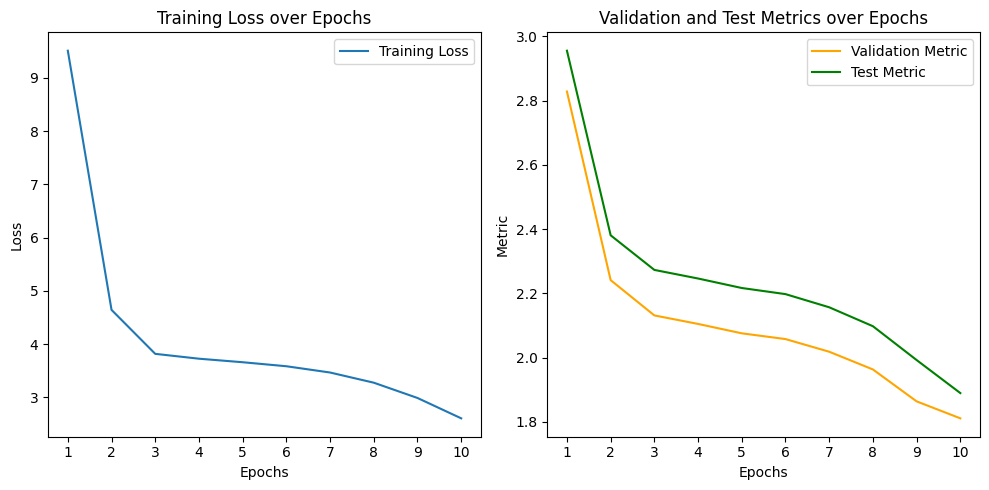

In [26]:
## Plotting function for training loss and validation/test metrics
def plot_curves(curves):
    epochs = range(1, len(curves["train"]) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves["train"], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()

    # Plot validation and test metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, curves["valid"], label='Validation Metric', color='orange')
    plt.plot(epochs, curves["test"], label='Test Metric', color='green')
    plt.title('Validation and Test Metrics over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

## Code to train model on a particular task
def train_model_on_task(task_name, model, node_feature_num, edge_feature_num, num_epochs=20, emb_dim=32, batch_size=32, lr_model=1e-4, lr_dec=1e-4):
    device = "cpu"
    s = time()

    ## Load dataset and evaluator
    dataset = PygGraphPropPredDataset(name=task_name)
    evaluator = Evaluator(task_name)
    split_idx = dataset.get_idx_split()

    ## Only retain the first node_feature_num node features and first edge_feature_num edges
    ## The # of node features in the dataset is 9 and edge features is 3, so can choose some slice of these features.
    print("Dataset x shape:", dataset.data.x.shape, "Dataset edge attr shape:", dataset.data.edge_attr.shape)
    dataset.data.x = dataset.data.x[:,:node_feature_num]
    dataset.data.edge_attr = dataset.data.edge_attr[:,:edge_feature_num]

    ## Make the split dataloaders
    train_loader = GraphormerDataLoader(dataset[split_idx["train"]], batch_size=batch_size, shuffle=True, num_workers = 1)
    valid_loader = GraphormerDataLoader(dataset[split_idx["valid"]], batch_size=batch_size, shuffle=False, num_workers = 1)
    test_loader = GraphormerDataLoader(dataset[split_idx["test"]], batch_size=batch_size, shuffle=False, num_workers = 1)

    ## Define model (transformer and prediction head/decoder) and optimizers
    model = model.to(device)
    decoder = NNDecoder(emb_dim = emb_dim, num_tasks = dataset.num_tasks).to(device)
    model_list = [model, decoder]

    optimizer = optim.Adam(model.parameters(), lr=lr_model)
    dec_optimizer = optim.Adam(decoder.parameters(), lr=lr_dec)
    optimizer_list = [optimizer, dec_optimizer]

    train_curve = []
    valid_curve = []
    test_curve = []
    train_val_curve = []

    ## Train the model and store loss/metrics
    for epoch in range(1, num_epochs + 1):
        train_perf = train(epoch, model_list, device, train_loader, optimizer_list, dataset.task_type)
        valid_perf = test(model_list, device, valid_loader, evaluator)
        test_perf = test(model_list, device, test_loader, evaluator)

        #Replace NaN values with 0.0
        valid_perf = {k: np.nan_to_num(v, nan=0.0) for k, v in valid_perf.items()}
        test_perf = {k: np.nan_to_num(v, nan=0.0) for k, v in test_perf.items()}

        print({'Train Loss': train_perf, 'Validation Metric': valid_perf, 'Test Metric': test_perf})

        train_curve.append(np.nan_to_num(train_perf, nan=0.0))
        valid_curve.append(valid_perf[dataset.eval_metric])
        test_curve.append(test_perf[dataset.eval_metric])

    if 'classification' in dataset.task_type:
        ## For classification metrics, the higher the better
        best_val_epoch = np.argmax(np.array(valid_curve))
    else:
        ## For regression metrics, the lower the better
        best_val_epoch = np.argmin(np.array(valid_curve))

    curves = {"train": train_curve, "valid": valid_curve, "test": test_curve}
    print('Best Validation Metric: {}'.format(valid_curve[best_val_epoch]))
    print('Test Metric: {}'.format(test_curve[best_val_epoch]))
    return valid_curve[best_val_epoch], test_curve[best_val_epoch], curves

def solubility():
    ## Here, our task is to predict the solubility of molecules in water; this is a regression task.
    ## Our metric is the mean-squared error between predicted and observed solubility values.
    node_feature_num = 4
    edge_feature_num = 2
    model = Graphormer(n_layers=3,
                       num_heads=5,
                       hidden_dim=32,
                       dropout_rate=0.1,
                       input_dropout_rate=0.1,
                       ffn_dim=32,
                       edge_type="multi_hop",
                       multi_hop_max_dist=5,
                       attention_dropout_rate=0.1,
                       node_feature_num=node_feature_num,
                       edge_feature_num=edge_feature_num,
                    )
    task_name = "ogbg-molesol"
    return train_model_on_task(task_name, model, node_feature_num, edge_feature_num, num_epochs = 10)

val_metric, test_metric, curves = solubility()
plot_curves(curves)


Our training pipeline is general enough that we can train our Graphormer on numerous other tasks, including all that tasks that are listed in this [spreadsheet](https://github.com/snap-stanford/ogb/blob/master/ogb/graphproppred/master.csv); interpretations of these datasets can be found on page 15 of this [paper](https://arxiv.org/pdf/2307.04052.pdf).

## Question 7 (15 points)

Train your model on a toxicity dataset (Tox21) in a similar manner as above. The task here is to predict 12 binary labels for each molecule that correspond to its toxicity on 12 different targets. The metric used here is AUC. Adjust the hyperparameters of your model and/or training procedure to ensure that your test AUC is greater than 0.7. Plot the train loss and val/test metrics over epochs using the function defined above.

In [27]:
def tox():
    ## A function that trains the Graphormer on the toxicity dataset.
    ############# Your code here ############
    ## (~5-15 lines of code)

    node_feature_num = 4
    edge_feature_num = 2

    model = Graphormer(
        n_layers=3,
        num_heads=5,
        hidden_dim=64,
        dropout_rate=0.1,
        input_dropout_rate=0.1,
        ffn_dim=128,
        edge_type="multi_hop",
        multi_hop_max_dist=5,
        attention_dropout_rate=0.1,
        node_feature_num=node_feature_num,
        edge_feature_num=edge_feature_num,
    )
    task_name = "ogbg-moltox21"

    return train_model_on_task(
        task_name,
        model,
        node_feature_num,
        edge_feature_num,
        emb_dim=64,
        lr_model=1e-5,
        lr_dec=1e-5,
    )

    #########################################

val_metric, test_metric, curves = tox()
plot_curves(curves)


/usr/local/lib/python3.11/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

Dataset x shape: torch.Size([145459, 9]) Dataset edge attr shape: torch.Size([302190, 3])


epoch: 1, train_loss: nan: 100%|████████████████████████████████████████████████████████████████| 196/196 [00:54<00:00,  3.63it/s]


ValueError: Input contains NaN.